In [1]:
import torch
import diffusers
from diffusers import StableDiffusionPipeline

device = (
    "mps"
    if torch.backends.mps.is_available()
    else "cuda"
    if torch.cuda.is_available()
    else "cpu"
)
print(device)

/home/ec2-user/StableVectors/venv/lib64/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda


In [2]:
model = "CompVis/stable-diffusion-v1-4"
pipeline = StableDiffusionPipeline.from_pretrained(model, torch_dtype=torch.float32).to(device)

100%|██████████| 50/50 [00:06<00:00,  7.16it/s]


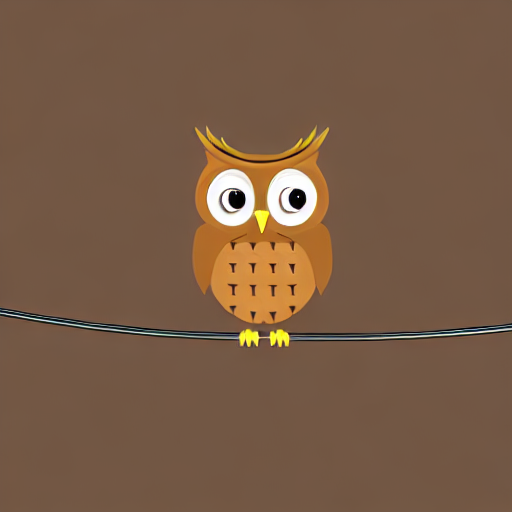

In [11]:
prompt = "an owl standing on a wire"
caption = " minimal flat 2d vector icon"
prompt = caption + prompt
image = pipeline(prompt).images[0] 
image 